# ResNet Setup

In [18]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import time

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
import copy
import pickle

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 8
BATCH_SIZE = 1
if torch.cuda.is_available():
    DEVICE = 'cuda:0' # default GPU device
else:
    DEVICE = 'cpu'
GRAYSCALE = False

In [3]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet101(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 23, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model

In [7]:
torch.manual_seed(RANDOM_SEED)

model = resnet101(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)
model.load_state_dict(torch.load('resnet_epoch50.pth'))

<All keys matched successfully>

In [8]:
custom_transform = transforms.Compose([transforms.Resize((178, 178)),
                                       transforms.CenterCrop((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])
image_datasets=datasets.ImageFolder(r'./val', custom_transform)

loader = torch.utils.data.DataLoader(image_datasets, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [9]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [10]:
model.eval()
compute_accuracy(model, loader, DEVICE)

tensor(97.5000, device='cuda:0')

# Load semantic data

In [11]:
with open('data/sem_items.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])
        
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(names_items)
print("List of relations:")
print(names_relations)
print("List of attributes:")
print(names_attributes)

List of items:
['Pine' 'Oak' 'Rose' 'Daisy' 'Robin' 'Canary' 'Sunfish' 'Salmon']
List of relations:
['ISA' 'Is' 'Can' 'Has']
List of attributes:
['Living thing' 'Plant' 'Animal' 'Tree' 'Flower' 'Bird' 'Fish' 'Pine'
 'Oak' 'Rose' 'Daisy' 'Robin' 'Canary' 'Sunfish' 'Salmon' 'Pretty' 'Big'
 'Living' 'Green' 'Red' 'Yellow' 'Grow' 'Move' 'Swim' 'Fly' 'Sing' 'Skin'
 'Roots' 'Leaves' 'Bark' 'Branch' 'Petals' 'Wings' 'Feathers' 'Gills'
 'Scales']


In [12]:
D = np.loadtxt('data/sem_data.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:8]])
print('Relation ',end='')
print(names_relations[input_v[8:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[1 0 0 0 0 0 0 0 1 0 0 0]
Example output pattern:
[1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['Pine']
Relation ['ISA']
Attributes ['Living thing' 'Plant' 'Tree' 'Pine']


# Training mynet

In [13]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE

        self.fwd1 = nn.Linear(nobj, rep_size)
        self.fwd2 = nn.Linear(nobj+nrel, hidden_size)
        self.fwd3 = nn.Linear(hidden_size, nattributes)


    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,nobj+nrel) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:nobj] # input to Item Layer [B x nobj Tensor]
        x_rel = x[:,nobj:] # input to Relation Layer [B x nrel Tensor]
        
        repitem = relu(self.fwd1(x_item))
        rep = torch.cat((repitem, x_rel), dim = 1)
        hidden = relu(self.fwd2(rep))
        output = torch.sigmoid(self.fwd3(hidden))

        
        
        return output, hidden, rep

In [14]:
nobj, nrel, nattributes

(8, 4, 36)

In [15]:
inp_dict = {}
out_dict = {}
for idx in range(NUM_CLASSES):
    output_patterns = D[idx*4:(idx+1)*4, nobj+nrel:]
    output_patterns = torch.tensor(output_patterns, dtype = torch.float)
    input_patterns = D[idx*4:(idx+1)*4, :nobj+nrel]
    input_patterns = torch.tensor(input_patterns, dtype = torch.float)
    out_dict[str(idx)] = output_patterns
    inp_dict[str(idx)] = input_patterns

In [16]:
def train(mynet,num_epochs):

    mynet.train()

    model.eval()
    out_layers = []
    rep_layers = []
    for e in range(num_epochs): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(nrel)
        ooo = []
        for  i, (features, targets) in enumerate(loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            _, lbl = torch.max(probas, 1)
            lbl = lbl.item()
            output_pats = out_dict[str(lbl)]
            input_pats = inp_dict[str(lbl)]
            oo = []
            for p in perm:
                mynet.zero_grad() # reset gradient
                output, hidden, rep = mynet(input_pats[p,:].cuda()) # forward pass
                target = output_pats[p,:].cuda()
                loss = criterion(output, target) # compute loss
                loss.backward() # compute gradient 
                optimizer.step() # update network parameters
                error_epoch += loss.item()
                oo.append(output.cpu().detach().numpy())
            ooo.append(np.concatenate(oo, axis = 0))
        error_epoch = error_epoch / float(N)        
        print('epoch ' + str(e) + ' loss ' + str(round(error_epoch,3)))
        out_layers.append(np.concatenate(ooo, axis = 0))
        rep_layers.append(get_rep(mynet))
    return out_layers, rep_layers

In [29]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(nobj,nobj+nrel)
    for idx,name in enumerate(names_items):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean.cuda())
    return rep.cpu().detach().numpy()

def plot_rep(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    nrows = nobj
    R = np.dstack((rep1,rep2,rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(7,12))
    plt.subplot(3,1,1)    
    dendrogram(linked1, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
    plt.ylabel('Euclidean distance')
    plt.subplot(3,1,2)
    plt.title("epoch " + str(nepochs_list[1]))
    dendrogram(linked2, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.show()

# load pretrained or retrain

In [17]:
load_pretrained = True


if load_pretrained:
    mynet = Net(rep_size=8,hidden_size=15)
    mynet.load_state_dict(torch.load('mynet_epoch200.pth'))
    mynet.to(DEVICE)
    with open('out_layer.pkl', 'rb') as file:
        out = pickle.load(file)
    with open('rep_layer.pkl', 'rb') as file:
        rep = pickle.load(file)
else:
    learning_rate = 0.1
    criterion = nn.MSELoss() # mean squared error loss function
    mynet = Net(rep_size=8,hidden_size=15)
    mynet.to(DEVICE)
    optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent
    out, rep = train(mynet,200)


# Saving model and layers

In [19]:

# with open('rep_layer.pkl', 'wb') as file:
#     pickle.dump(rep, file)
    
# with open('out_layer.pkl', 'wb') as file:
#     pickle.dump(out, file)

#save mynet
# torch.save(mynet.state_dict(), 'mynet_epoch200.pth')

# Plot rep and dendo

In [33]:
e1 = 50
e2 = 120
e3 = 199

nepochs_phase1 = e1
nepochs_phase2 = e2
nepochs_phase3 = e3

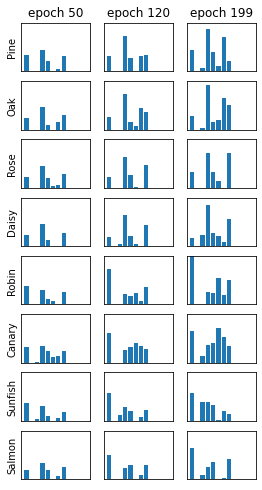

In [34]:
plot_rep(rep[e1], rep[e2], rep[e3], names_items)

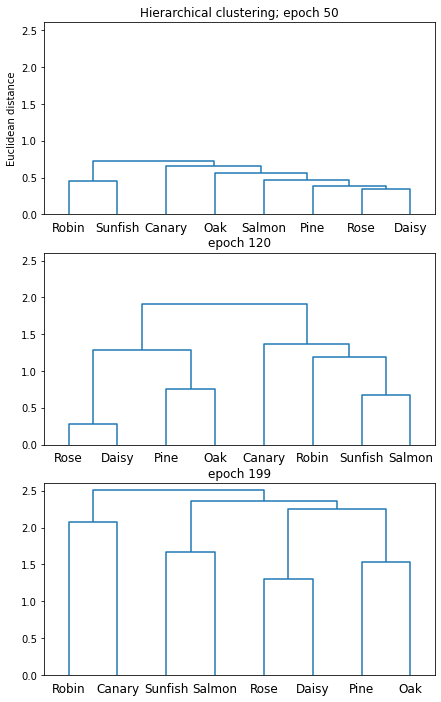

In [35]:
plot_dendo(rep[e1], rep[e2], rep[e3], names_items)

# Plot degradation

## Gaussian Noise

In [103]:
def apply_gaussian_noise(net,scale) :
    
    model = copy.deepcopy(net) #otherwise actual model might change in place.
    model.eval()
    new_weights = model.state_dict()

    
    # add mutlivariate random matrix element-wise to weights.
    noisy_add = np.random.normal(loc=0,scale=scale,
                                 size=new_weights['fwd1.weight'].size())
    
    new_weights['fwd1.weight'] += noisy_add
    model.load_state_dict(new_weights)
    
    return model

def apply_dropout_noise(net,probability) :
    
    model = copy.deepcopy(net) #otherwise actual model might change in place.
    model.eval()
    new_weights = model.state_dict()

    dim1,dim2 = new_weights['fwd1.weight'].size()
    
    rand_use = np.random.random(size=dim1) > probability
    weights_new = (rand_use.astype(int)).reshape(dim1,1) * new_weights['fwd1.weight'].cpu().detach().numpy()
    
    new_weights['fwd1.weight'] = torch.tensor(weights_new)
    model.load_state_dict(new_weights)
    
    return model

def Categorize_Outputs(net,general_names,intermediate_names,specific_names,relation_eval) :
    
    ind_relation = np.where(names_relations == relation_eval)[0][0]

    patterns_eval = input_pats[ind_relation::len(names_relations)]
    patterns_truth = output_pats[ind_relation::len(names_relations)]
    general_out = []
    intermediate_out = []
    specific_out = []
    negative_out = []

    for i,pattern in enumerate(patterns_eval) :
        true_output_bool = patterns_truth[i].cpu().detach().numpy().astype('bool')
        names_eval = names_attributes[true_output_bool]
        mod_output = net(pattern)[0].cpu().detach().numpy()[0][true_output_bool]  
        for j,name in enumerate(names_eval) :
            if name in general_names :
                general_out.append(mod_output[j])
            if name in intermediate_names :
                intermediate_out.append(mod_output[j])
            if name in specific_names :
                specific_out.append(mod_output[j])
                
    inds_truth = np.argwhere(patterns_truth.cpu().detach().numpy())
    inds_false = np.argwhere(patterns_truth.cpu().detach().numpy() == 0)

    inds_false = inds_false[np.isin(inds_false[:,1],list(set(inds_truth[:,1])))]
    negative_outputs = net(patterns_eval)[0].cpu().detach().numpy()[inds_false[:,0],inds_false[:,1]]
                
    return np.mean(general_out),np.mean(intermediate_out),np.mean(specific_out),np.mean(negative_outputs)

def Noise_Degredation(net,scales,num_run,fnc_noise,fnc_categorize,general_names,
                      intermediate_names,specific_names,relation_eval) :
    
    noise_stats = {item:{scale:[] for scale in scales} for 
                   item in ['general','narrowed','specific','false']}

    for scale in scales :
        for _ in range(num_run) :
            model = fnc_noise(net,scale)
            g_out,int_out,s_out,neg_out = fnc_categorize(model,general_names,intermediate_names,
                                                 specific_names,relation_eval)
            
            noise_stats['general'][scale].append(g_out)
            noise_stats['narrowed'][scale].append(int_out)
            noise_stats['specific'][scale].append(s_out)
            noise_stats['false'][scale].append(neg_out)
            
    return noise_stats

In [131]:
mynet.to('cpu')
for idx, attr in enumerate(names_attributes):
    print(attr, idx)

Living thing 0
Plant 1
Animal 2
Tree 3
Flower 4
Bird 5
Fish 6
Pine 7
Oak 8
Rose 9
Daisy 10
Robin 11
Canary 12
Sunfish 13
Salmon 14
Pretty 15
Big 16
Living 17
Green 18
Red 19
Yellow 20
Grow 21
Move 22
Swim 23
Fly 24
Sing 25
Skin 26
Roots 27
Leaves 28
Bark 29
Branch 30
Petals 31
Wings 32
Feathers 33
Gills 34
Scales 35


In [156]:
# # For ISA #best explained
# general = names_attributes[:3]
# intermediate = names_attributes[3:7]
# specific = names_attributes[7:15]

# Is
# specific = names_attributes[18]
# general = names_attributes[15:18]
# intermediate = names_attributes[18:21]

# Can

# general = names_attributes[21]
# intermediate = names_attributes[22:26]
# specific = names_attributes[22:26]

# Has
general = names_attributes[26:28]
intermediate = names_attributes[28:30]
specific = names_attributes[30:35]



relation_eval = 'Has'
scales_use = np.linspace(0,8,8)

ind_relation = np.where(names_relations == relation_eval)[0][0]
patterns_eval = input_pats[ind_relation::len(names_relations)]
patterns_truth = output_pats[ind_relation::len(names_relations)]

noisy_outputs = Noise_Degredation(mynet,scales_use,60,
                                  apply_gaussian_noise,Categorize_Outputs,
                                  general,intermediate,specific,relation_eval)

noise_formatted = {} 
for k,v in noisy_outputs.items() :
    noise_formatted[k] = {}
    for scale,vals in v.items() :
        noise_formatted[k][scale] = {}
        noise_formatted[k][scale]['mean'] = np.mean(vals,axis=0)
        noise_formatted[k][scale]['std'] = np.std(vals,axis=0)

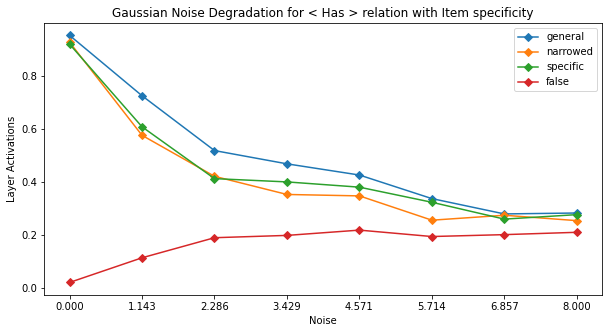

In [157]:
plt.figure(figsize=(10,5))
for k,v in noise_formatted.items() :
    to_plot = [v[scale]['mean'] for scale in v.keys()]
    to_plot_error = [v[scale]['std'] for scale in v.keys()]
    #plt.errorbar(scales_use,to_plot,yerr=to_plot_error,label=k,marker='D')
    plt.plot(scales_use, to_plot, label = k, marker = 'D')
plt.legend()
plt.xticks(scales_use)
plt.yticks()
plt.title('Gaussian Noise Degradation for < {} > relation with Item specificity'.format(relation_eval))
plt.xlabel('Noise')
plt.ylabel('Layer Activations')
plt.show()

## Dropout degradation

In [158]:
probabilities_use = np.linspace(0,1,8)
relation_eval= 'Has'

noisy_outputs = Noise_Degredation(mynet,probabilities_use,60,
                                  apply_dropout_noise,Categorize_Outputs,
                                  general,intermediate,specific,relation_eval)

noise_formatted = {} 
for k,v in noisy_outputs.items() :
    noise_formatted[k] = {}
    for scale,vals in v.items() :
        noise_formatted[k][scale] = {}
        noise_formatted[k][scale]['mean'] = np.mean(vals,axis=0)
        noise_formatted[k][scale]['std'] = np.std(vals,axis=0)

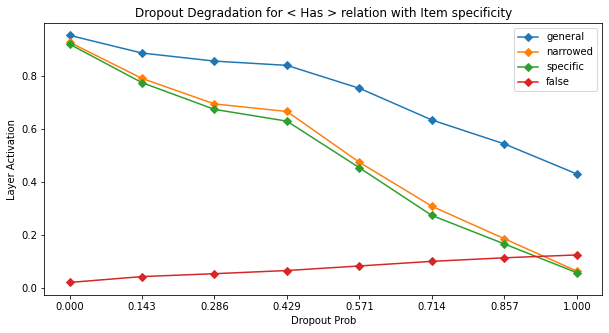

In [159]:
plt.figure(figsize=(10,5))
for k,v in noise_formatted.items() :
    to_plot = [v[scale]['mean'] for scale in v.keys()]
    to_plot_error = [v[scale]['std'] for scale in v.keys()]
    #plt.errorbar(probabilities_use,to_plot,yerr=to_plot_error,label=k,linestye=None,marker='D')
    plt.plot(probabilities_use, to_plot, label = k, marker = 'D')
#plt.hlines(y=.5,xmin=0,xmax=max(probabilities_use),linestyle='--')
plt.legend()
plt.xticks(probabilities_use)
plt.yticks()
plt.title('Dropout Degradation for < {} > relation with Item specificity'.format(relation_eval))
plt.xlabel('Dropout Prob')
plt.ylabel('Layer Activation')
plt.show()

# Plot species learning curve (bugged)

In [ ]:
# # copy mynet to cpu
# mynet.to('cpu')

# def Species_Epoch(species,output_layers) :
    
#     if species not in names_items :
#         raise ValueError('Invalid species name')
    
#     ind_species = np.where(names_items == species)[0]
#     input_inds = np.where(input_pats[:,ind_species] == 1)[0]

#     characteristics = {val:{} for val in names_relations}
#     for n in range(len(output_layers)) :
#         for i,v in enumerate(names_relations) :
#             input_species = input_pats[input_inds[i]]
#             output_species = output_layers[n][input_inds[i]]
#             true_output = output_pats[input_inds[i]]

#             rels_look = names_attributes[true_output.detach().numpy().astype('bool')] #

#             for j,item in enumerate(rels_look) :
#                 if item in characteristics[v] :
#                     characteristics[v][item].append(output_species[true_output.detach().numpy().astype('bool')][j]) #
#                 else :
#                     characteristics[v][item] = [output_species[true_output.detach().numpy().astype('bool')][j]]#
                    
#     return characteristics

# def plot_epoch_per_species(fnc_create_data,species,output_layers) :
    
#     char_out = fnc_create_data(species,output_layers)
    
#     fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10),sharex=True,sharey=True)
#     row,col = 0,0
#     for key in char_out.keys() :
#         for k,v in char_out[key].items() :
#             axes[row][col].plot(list(range(len(output_layers)))[30:],v[30:],label = key+"_"+k)
#         axes[row][col].legend()
#         axes[row][col].set_xlabel('Epoch',fontsize=15)
#         axes[row][col].set_ylabel('Activation',fontsize=15)
#         axes[row][col].tick_params('both',labelsize=15)
#         axes[row][col].set_title(species+' '+key,fontsize=20)
#         if row == 1 :
#             row -= 1
#             col += 1
#         else :
#             row += 1

# plot_epoch_per_species(Species_Epoch,'Pine',final_ooo)